## 卡尔曼滤波

参考：

[卡尔曼滤波公式推导](https://zhuanlan.zhihu.com/p/649997859)

[卡尔曼滤波（Kalman Filter）深入解析：从零开始彻底搞懂预测与修正](https://blog.csdn.net/navsense_support/article/details/146231513)

[Python卡尔曼滤波器OpenCV跟踪和预测物体的轨迹](https://viadean.notion.site/Python-OpenCV-142252662e5f4552b6e7b6d8ae60952b)

[官方文档](https://docs.opencv.org/4.1.2/dd/d6a/classcv_1_1KalmanFilter.html#a077d73eb075b00779dc009a9057c27c3)

卡尔曼滤波器是一种广泛应用于目标跟踪、状态估计等领域的高效算法。它通过递归的方式，利用系统的动态模型和观测数据，对系统的状态进行最优估计

## 原理

卡尔曼滤波的思想其实很简单，就是不断进行“预测”和“修正”：

- 预测：基于之前的数据，估算当前的值
- 修正：用传感器或测量数据，对预测值进行调整，使其更加准确
- 重复上述步骤，不断优化，使误差越来越小

卡尔曼滤波器主要有两个步骤：

1. 预测步骤（Prediction Step）：
   - 根据系统的动态模型，预测当前时刻的状态和误差协方差。
   - 公式：
     - 状态预测：$\hat{x}_{k} = A \hat{x}_{k-1} + B u_k$，其中：
       - $\hat{x}$ 是预测状态向量，表示系统在时刻$k$的状态
       - $A$ 是状态转移矩阵，描述状态如何从上一个时刻$k−1$变化到当前时刻$k$
       - $B$ 是控制输入矩阵，控制输入对状态的影响程度
       - $u_k$ 是控制输入向量，表示外部施加的影响，如果无外部输入，$B u_k$可忽略
     - 误差协方差预测：$P_{k} = A P_{k-1} A^T + Q_k$，其中:
       - $Q$ 是过程噪声协方差矩阵，$Q_k=E[w_k w_k^T]$，$E$表示期望，$w_k$是过程噪声向量，反映系统动态模型的不确定性
       - $P$ 是误差协方差矩阵，反映了预测结果的不确定性
2. 更新步骤（Update Step）：
   - 利用观测数据，对预测的状态进行修正。
   - 公式：
     - 计算卡尔曼增益：$K_k = P_{k} H^T (H P_{k} H^T + R)^{-1}$，其中：
       - $H$ 是观测矩阵，描述如何从预测状态向量$\hat{x}$映射到观测空间，有的时候测量设备只能观测到状态的一部分，需要从状态变量中提取出这部分信息，例如：$速度=H\times[位置;速度]$
       - $R$ 是观测噪声协方差矩阵，R值一般不是计算得出的，而是通过设备说明或实验确定的，反映观测数据的不确定性
       - $K_k$ 是卡尔曼增益，在进行估计修正时用的权重值，决定了预测值和观测值的相对重要性
     - 更新状态估计：$\hat{x}_{k} = \hat{x}_{k-1} + K_k (z_k - H \hat{x}_{k-1})$，其中：
       - $z_k$ 是实际观测值向量
     - 更新误差协方差：$P_{k} = (I - K_k H) P_{k-1}$，其中：
       - $I$ 是单位矩阵

解释公式：$K_k = P_{k} H^T (H P_{k} H^T + R)^{-1}$

- $HP_kH^T$把预测误差从状态空间映射到测量空间
- $P_kH^T$得出状态误差与观测误差之间的关联
- $HP_kH^T + R$把预测带来的测量空间误差和测量本身的误差相加，得到总误差
- 整体上看，$K_k$等于“预测误差与总误差的比值”，即$K_k = \frac{预测误差}{预测误差 + 测量误差}$

由上式可知：卡尔曼滤波器将**测量值与预测值加权平均**，得到一个更准确的估计值。权重的分配取决于预测值和测量值的置信度，即下文的Q：过程噪声协方差矩阵，R：观测噪声协方差矩阵，$Q$相对于$R$越大，说明更相信观测。反之$R$相对于$Q$越大，说明更相信预测

## opencv实现

使用`cv2.KalmanFilter`类来实现卡尔曼滤波器

`cv2.kalmanFilter(stateDim, measDim, contrDim=0, type=cv2.CV_32F)`

参数说明：

- `stateDim`：状态向量的维度
- `measDim`：测量向量的维度
- `contrDim`：控制向量的维度（可选，默认为0）
- `type`：数据类型（默认为`cv2.CV_32F`）

类中的主要方法和属性：

属性：

- `transitionMatrix`: 状态转移矩阵$A$
- `controlMatrix`: 控制输入矩阵$B$
- `processNoiseCov`: 过程噪声协方差矩阵$Q$
- `measurementMatrix`: 测量矩阵$H$
- `measurementNoiseCov`: 测量噪声协方差矩阵$R$
- `statePre`: 预测的状态向量$x_k$
- `statePost`: 修正后的状态向量$x_k$
- `errorCovPost`: 后验误差协方差矩阵$P_k$
- 

方法：

- `predict()`: 进行状态预测
- `correct(measurement)`: 使用测量值进行状态修正

下面我们模拟一个对象的简单2D运动并使用卡尔曼滤波器来估计其位置：

必须初始化的值：

- 状态转移矩阵（transitionMatrix A）
  $$\begin{bmatrix}x+Vx\\y+Vy\\Vx\\Vy\end{bmatrix}=\begin{bmatrix}1&0&1&0\\0&1&0&1\\0&0&1&0\\0&0&0&1\end{bmatrix}\times\begin{bmatrix}x\\y\\Vx\\Vy\end{bmatrix}$$

  如果时间步长 dt ≠ 1，transitionMatrix 中要把速度项乘以 d
- 观测矩阵（measurementMatrix H）
$$\begin{bmatrix}x\\y\end{bmatrix}=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}\times\begin{bmatrix}x\\y\\Vx\\Vy\end{bmatrix}$$

- 初始状态（statePost）
- 初始协方差（errorCovPost）

过程噪声协方差（processNoiseCov Q）和观测噪声协方差（measurementNoiseCov R）虽然有默认值，但通常需要根据问题调参以得到合理结果

实现逻辑：

用上一次的后验估计 $x_{k-1|k-1}$ 通过状态转移 $A$ 预测出当前时刻的先验 $x_{k|k-1}$（即在看到观测前对当前时刻的估计），再使用当前时刻的观测 $z_k$ 修正这个先验，得到当前时刻的后验 $x_{k|k}$（最终估计）

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 初始化卡尔曼滤波器
kalman_2d = cv2.KalmanFilter(4, 2) # 状态向量维度4，[x,y,Vx,Vy],测量向量维度2，[x,y]
kalman_2d.transitionMatrix = np.array([ # A
    [1, 0, 1, 0], 
    [0, 1, 0, 1], 
    [0, 0, 1, 0], 
    [0, 0, 0, 1]], np.float32)
kalman_2d.measurementMatrix = np.array([ # H
    [1, 0, 0, 0], 
    [0, 1, 0, 0]], np.float32)
kalman_2d.processNoiseCov = np.eye(4, dtype=np.float32)*1e-5*0.2 # Q，eye()用于创建二维数组，其中对角线为1，其他地方为0
kalman_2d.measurementNoiseCov = np.eye(2, dtype=np.float32)*1e-2*0.5 # R

# 生成真实路径与观测噪声
t = np.linspace(0, 4 * np.pi, 100) # 在指定的区间内生成等间隔的数值
x = t # 横坐标
y = np.sin(t) # 纵坐标
true_path = np.vstack((x, y)).T # 拼接出shape(100,2)的真实坐标数组
measurements = true_path + np.random.normal(0, 0.2, size=true_path.shape) # 加入高斯噪声得到观测路径点集

- 如果估计噪声震荡太大，减小 Q 或增大 R
- 如果跟踪延迟或滞后，增大 Q 或减小 R

- Q（过程噪声协方差）越大 → 卡尔曼滤波更“相信观测”（卡尔曼增益 K 增大）→ 响应更快但估计更噪声（振荡增大）。
- R（测量噪声协方差）越大 → 更不信观测（K 变小）→ 估计更平滑但对突变响应慢（滞后增大）

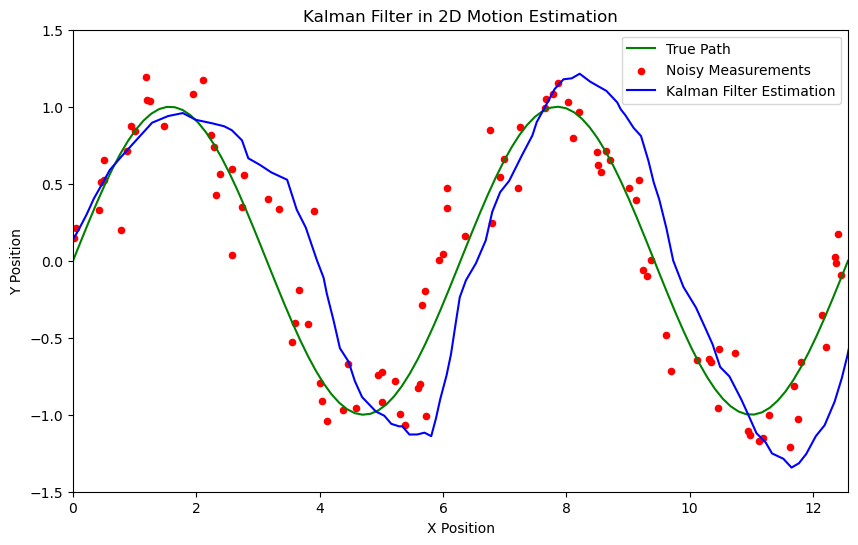

In [33]:
# 卡尔曼滤波循环
state = np.array([[measurements[0,0]],[measurements[0,1]],[0.0],[0.0]], dtype=np.float32)
kalman_2d.statePost = state
predictions = []

# 从第二个测量开始，与 predict() 的“下一时刻”对齐
for m in measurements[1:]: # measurements[1:] 是 Python 的切片语法，意思是从索引 1 开始取直到末尾（不含索引 0）
    prediction = kalman_2d.predict() # 先验 x_{k|k-1}
    measurement = np.array([[np.float32(m[0])],[np.float32(m[1])]])
    corrected = kalman_2d.correct(measurement) # 后验 x_{k|k}
    predictions.append(corrected.copy())

predictions = np.array(predictions)  # shape: (N, 4, 1)，绘图时用predictions[:,0,0]取x，predictions[:,1,0]取y

# 绘制图表
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 4 * np.pi)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Kalman Filter in 2D Motion Estimation")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.plot(true_path[:, 0], true_path[:, 1], 'g-', label="True Path")
ax.scatter(measurements[:, 0], measurements[:, 1], c='red', s=20, label="Noisy Measurements")
ax.plot(predictions[:, 0, 0], predictions[:, 1, 0], 'b-', label="Kalman Filter Estimation")
ax.legend()
plt.show()

## 实战

实时估计物体位置并在丢失目标时画出预测轨迹

我们以一个常见的应用场景为例，即在摄像头画面中持续追踪一物体，绘制其实际位置与估计位置，那么处理流程如下：

- 初始化：建立KalmanFilter，设置A/H/Q/R，设定初始statePost与errorCovPost，记录missed_count=0
- 每帧循环：
  - 使用predict()得到先验statePre
  - 运行目标检测
    - 如果检测到目标：
      - 绘制`测量位置`，构造测量值`z`，missed_count = 0
      - 调用`correct(z)`得到后验statePost，绘制出`估计位置`
    - 如果未检测到目标：仅使用predict的输出绘制位置, missed_count += 1
      - 当 missed_count > threshold 报错

In [3]:
def track_aruco(frame, aruco_dict):
    aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, _ = detector.detectMarkers(frame)
    centers = []
    if corners is None or len(corners) == 0:
        return None, None, None
    for c in corners:
        pts = np.asarray(c).reshape(-1, 2)
        cx = int(np.mean(pts[:, 0]))
        cy = int(np.mean(pts[:, 1]))
        centers.append((cx, cy))
    return corners, ids, centers

In [2]:
def predict_aruco(centers, ids, kalman, missed_count):
    # 返回 (prediction, missed_count, corrected_flag)
    prediction = kalman.predict()
    # prediction 形状通常为 (4,1) 或可索引为 prediction[0,0], prediction[1,0]
    if ids is not None and centers:
        measurement = np.array([[np.float32(centers[0][0])], [np.float32(centers[0][1])]])
        corrected = kalman.correct(measurement)
        missed_count = 0
        return corrected, missed_count, True
    else:
        missed_count += 1
        return prediction, missed_count, False

In [ ]:
# 绘制检测框，预测框和中心点
def draw_aruco(frame, corners, centers, prediction, ids, latest_detected_box):
    if ids is not None and corners is not None:
        for i, corner in enumerate(corners):
            corner_points = corner[0].astype(np.int32)
            x, y, w, h = cv2.boundingRect(corner_points)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if centers and i < len(centers):
                cv2.circle(frame, (centers[i][0], centers[i][1]), 5, (255, 0, 0), -1)
            latest_detected_box = (w, h)
    # prediction 可以是 predict() 或 correct() 的返回
    if prediction is not None:
        pred_x = int(prediction[0, 0])
        pred_y = int(prediction[1, 0])
        cv2.circle(frame, (pred_x, pred_y), 5, (0, 0, 255), -1)
        if latest_detected_box is not None:
            w, h = latest_detected_box
            cv2.rectangle(frame, (pred_x - w//2, pred_y - h//2), (pred_x + w//2, pred_y + h//2), (255, 0, 255), 2)
    return frame, latest_detected_box

In [ ]:
def main():
    # 初始化Aruco标记字典
    aruco_dict=cv2.aruco.DICT_5X5_100
    # 初始化卡尔曼滤波器
    kalman=cv2.KalmanFilter(4,2)
    kalman.transitionMatrix = np.array([
        [1, 0, 1, 0], 
        [0, 1, 0, 1], 
        [0, 0, 1, 0], 
        [0, 0, 0, 1]], np.float32)
    kalman.measurementMatrix = np.array([
        [1, 0, 0, 0], 
        [0, 1, 0, 0]], np.float32)
    # 设置噪声协方差矩阵，给速度赋予更大的不确定性
    kalman.processNoiseCov = np.diag([1e-4, 1e-4, 5e-4, 5e-4]).astype(np.float32)
    # 设置测量噪声协方差矩阵
    kalman.measurementNoiseCov = np.eye(2, dtype=np.float32)*1e-2
    # 设置后验误差协方差矩阵，使滤波器更容易根据测量调整状态（特别是速度）
    kalman.errorCovPost = np.eye(4, dtype=np.float32) * 1.0
    # 初始化变量
    initialized = False
    missed_count = 0
    latest_detected_box = None
    is_save = False
    save_path = "./images/kalman.mp4"
    # 视频帧处理
    cap=cv2.VideoCapture(1)
    # 保存视频设置
    if is_save:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))
    if not cap.isOpened():
        print("Error: Could not open camera.")
        exit()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # 追踪Aruco标记
        corners, ids, centers = track_aruco(frame, aruco_dict)
        # 初始化卡尔曼滤波器的statePost
        if not initialized and ids is not None:
            cx, cy = centers[0]
            kalman.statePost = np.array([[np.float32(cx)], [np.float32(cy)], [0.0], [0.0]], dtype=np.float32)
            initialized = True
        # 进行预测与校正
        prediction, missed_count, corrected_flag = predict_aruco(centers, ids, kalman, missed_count)
        frame, latest_detected_box = draw_aruco(frame, corners, centers, prediction, ids, latest_detected_box)
        if missed_count > 20:
            cv2.putText(frame, "Marker lost", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow('camera1', frame)
        # 保存
        if is_save :
            out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
if __name__=="__main__":
    main()